In [1]:
dp0_limits = [[48, 76], [-44,-28]] # [ra_lim, dec_lim]
import random
import time
from tqdm import tqdm
import os
from datetime import datetime
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from lsst.afw import table as afwTable
from lsst.source.injection import (
    ingest_injection_catalog, generate_injection_catalog,
    VisitInjectConfig, VisitInjectTask
)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import getpass

import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom

from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.base import ForcedMeasurementTask
import lsst.daf.base as dafBase
from light_curves import LightCurve

from scipy.spatial import KDTree
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from astropy.coordinates import SkyCoord
from lsst.sphgeom import HtmPixelization, UnitVector3d, LonLat
from shapely.geometry import Polygon, Point

from tools import tri_sample, triangle_min_height, circ_sample

## Obtain calexp to inject

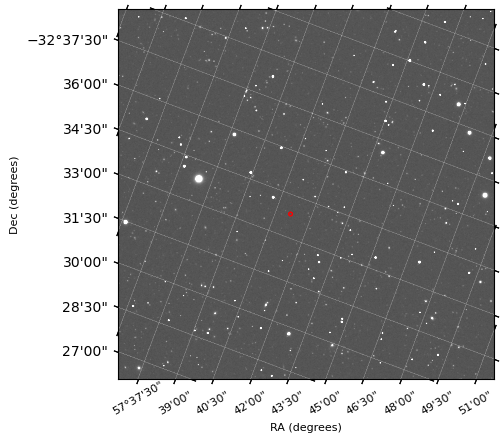

In [2]:
from exposures import Calexp
calexp = Calexp({"visit":6855, "detector":117})
ax = calexp.plot()
ra_o, dec_o = calexp.wcs.getSkyOrigin()
ra, dec = ra_o.asDegrees()-0.02,dec_o.asDegrees()+0.01
calexp.add_point(ax, ra, dec, r=20)

## Injection

In [3]:
# inject task
from lsst.source.injection import VisitInjectConfig, VisitInjectTask

inject_config = VisitInjectConfig()
injection_task = VisitInjectTask(config=inject_config)


In [4]:
# search mjd
from lsst.daf.butler import Butler
# butler_config = 'dp02'
butler_config = 'dp02-direct'
collections = '2.2i/runs/DP0.2'
butler = Butler(butler_config, collections=collections)
datarefs = butler.get('ccdVisitTable')
mjd = datarefs[(datarefs["visitId"] == 6855) & (datarefs["detector"] == 117)]['expMidptMJD']

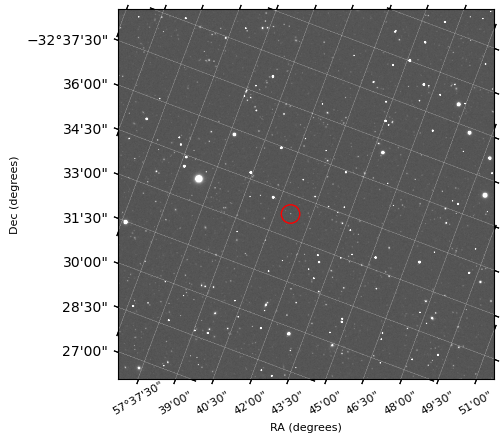

In [5]:
# inject_calexp(self, calexp, save_fit = None):
from astropy.table import Table

data = [0, calexp.data_id["visit"], calexp.data_id["detector"], ra, dec,"Star", mjd, 20.6]
aux = []
for d in data:
    aux.append([d])
inject_table =  Table(aux, names=['injection_id', 'visit', 'detector', 'ra', 'dec', 'source_type', 'exp_midpoint', 'mag'])

injected_output = injection_task.run(
                    injection_catalogs=[inject_table],
                    input_exposure=calexp.expF.clone(),
                    psf=calexp.expF.getPsf(),
                    photo_calib=calexp.expF.getPhotoCalib(),
                    wcs=calexp.wcs)
injected_exposure = injected_output.output_exposure
injected_catalog = injected_output.output_catalog
new_calexp = Calexp(injected_exposure)
ax = new_calexp.plot()
new_calexp.add_point(ax, ra, dec, r=100)



## Detection

In [12]:
new_calexp.mask.removeAndClearMaskPlane('DETECTED')
schema = afwTable.SourceTable.makeMinimalSchema()
raerr = schema.addField("coord_raErr", type="F")
decerr = schema.addField("coord_decErr", type="F")
algMetadata = dafBase.PropertyList()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 4
config.thresholdType = "stdev"
detection_task = SourceDetectionTask(schema=schema, config=config)
tab = afwTable.SourceTable.make(schema)
result = detection_task.run(tab, new_calexp.expF)
sources = result.sources

## Measurement

#### ForcedMeasurementTask

In [7]:
schema = afwTable.SourceTable.makeMinimalSchema()
alias = schema.getAliasMap() 
x_key = schema.addField("centroid_x", type="D")
y_key = schema.addField("centroid_y", type="D")
alias.set("slot_Centroid", "centroid")

xx_key = schema.addField("shape_xx", type="D")
yy_key = schema.addField("shape_yy", type="D")
xy_key = schema.addField("shape_xy", type="D")
alias.set("slot_Shape", "shape")
type_key = schema.addField("type_flag", type="F")
config = ForcedMeasurementTask.ConfigClass()
config.copyColumns = {}
config.plugins.names = [
    "base_TransformedCentroid",
    "base_PsfFlux",
    "base_TransformedShape"
]
config.doReplaceWithNoise = False
forcedMeasurementTask = ForcedMeasurementTask(schema, config=config)
del config

In [12]:
ra_inj = injected_catalog["ra"]; dec_inj =  injected_catalog["dec"]

injection_id,injection_flag,injection_draw_size,visit,detector,ra,dec,source_type,exp_midpoint,mag
int64,int64,int64,int64,int64,float64,float64,str13,float64[1],float64
0,0,24,6855,117,57.685470874485695,-32.56375716583206,DeltaFunction,59589.21471821991,20.6


In [13]:
forcedSource = afwTable.SourceCatalog(schema)
for source in injected_catalog:
    sourceRec = forcedSource.addNew()
    coord = geom.SpherePoint(geom.Angle(source["ra"], geom.degrees).asRadians(),geom.Angle(source["dec"], geom.degrees).asRadians(), geom.radians)
    sourceRec.setCoord(coord)
    sourceRec[x_key], sourceRec[y_key]= new_calexp.sky_to_pix(source["ra"], source["dec"])
    sourceRec[type_key] = 0
# del sourceRec, coord
forcedSource[0]

<class 'lsst.afw.table.SourceRecord'>
id: 1
coord_ra: 1.0068 rad
coord_dec: -0.568345 rad
parent: 0
centroid_x: 1866
centroid_y: 1786
shape_xx: nan
shape_yy: nan
shape_xy: nan
type_flag: 0

In [27]:
forcedMeasCat = forcedMeasurementTask.generateMeasCat(new_calexp.expF, forcedSource, new_calexp.wcs)
forcedMeasurementTask.run(forcedMeasCat, new_calexp.expF, forcedSource, new_calexp.wcs)
table = forcedMeasCat.asAstropy()

In [30]:
table["slot_Centroid_x"]

1866.0


In [10]:
flux, flux_err = table["base_PsfFlux_instFlux"], table["base_PsfFlux_instFluxErr"]
new_calexp.get_mag(flux, flux_err)

In [22]:
table = pd.DataFrame(columns=["ra", "dec", "flux", "flux_err", "mag", "mag_err", "flag"])
table["ra"] = injected_catalog["ra"]; table["dec"] = injected_catalog["dec"]
table.loc[(table["ra"] == ra) & (table["dec"] == dec), ["flux", "flux_err", "mag", "mag_err"]] = [1,2,3,4] 
table

,ra,dec,flux,flux_err,mag,mag_err,flag
0,57.685471,-32.563757,1,2,3,4,NaN


In [20]:
table.loc[table["ra"] == ra]=[3
table

,ra,dec,flux,flux_err,mag,mag_err,flag
0,57.685471,-32.563757,NaN,NaN,NaN,NaN,NaN


#### SingleFrameMeasurementTask

In [7]:
# measure task
from lsst.afw import table as afwTable
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.algorithms import SourceDetectionTask
import lsst.daf.base as dafBase

config = SingleFrameMeasurementTask.ConfigClass()
measurment_task = SingleFrameMeasurementTask(schema=schema,
                                                   config=config,
                                                   algMetadata=algMetadata)

In [8]:
# measure calexp
tab = afwTable.SourceTable.make(schema)
result = detection_task.run(tab, new_calexp.expF)
sources = result.sources
# sources = calexp.get_sources(self.tasks["Detection"], schema)
measurment_task.run(measCat=sources, exposure=new_calexp.expF)


In [9]:
sources

<class 'lsst.afw.table.SourceCatalog'>
 id       coord_ra      ... base_InvalidPsf_flag
            rad         ...                     
---- ------------------ ... --------------------
   1 1.0058571469182698 ...                False
   2 1.0064684121304373 ...                False
   3 1.0066392672049589 ...                False
   4 1.0094743069428787 ...                False
   5 1.0094925789800941 ...                False
   6 1.0098455926878291 ...                False
   7 1.0078934463495302 ...                False
   8 1.0057407157512044 ...                False
   9 1.0084031411966006 ...                False
 ...                ... ...                  ...
2602 1.0058293726119643 ...                False
2603 1.0045966219586218 ...                False
2604 1.0057378133027417 ...                False
2605  1.007460535761644 ...                False
2606 1.0066994006671777 ...                False
2607 1.0068430649735804 ...                False
2608  1.003993488449541 ...   

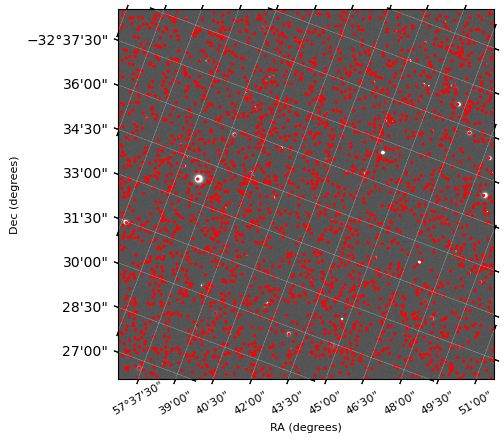

In [11]:
# config.thresholdValue = 4
ax = new_calexp.plot()
for i in range(len(sources)):
    new_calexp.add_point(ax,sources[i]["coord_ra"].asDegrees(), sources[i]["coord_dec"].asDegrees(), r = 10)

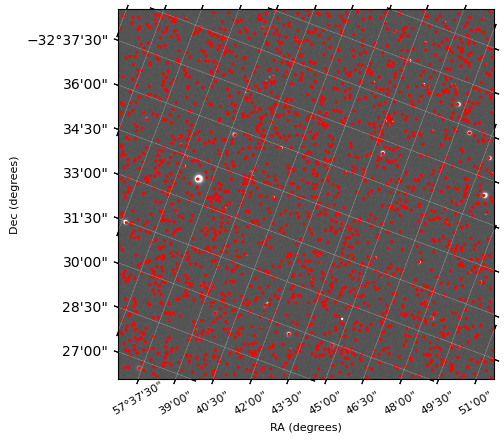

In [12]:
# measure task config.thresholdValue = 5
from lsst.afw import table as afwTable
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.algorithms import SourceDetectionTask
import lsst.daf.base as dafBase

schema = afwTable.SourceTable.makeMinimalSchema()
raerr = schema.addField("coord_raErr", type="F")
decerr = schema.addField("coord_decErr", type="F")
algMetadata = dafBase.PropertyList()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 5
config.thresholdType = "stdev"
detection_task = SourceDetectionTask(schema=schema, config=config)
config = SingleFrameMeasurementTask.ConfigClass()
measurment_task = SingleFrameMeasurementTask(schema=schema,
                                                   config=config,
                                                   algMetadata=algMetadata)
# measure calexp
tab = afwTable.SourceTable.make(schema)
result = detection_task.run(tab, new_calexp.expF)
sources = result.sources
# sources = calexp.get_sources(self.tasks["Detection"], schema)
measurment_task.run(measCat=sources, exposure=new_calexp.expF)

ax = new_calexp.plot()
for i in range(len(sources)):
    new_calexp.add_point(ax,sources[i]["coord_ra"].asDegrees(), sources[i]["coord_dec"].asDegrees(), r = 5)


(Measurement(value=20.59963930354939521, error=0.01518406234051837382),
 20.584455241208875,
 20.614823365889915,
 True)

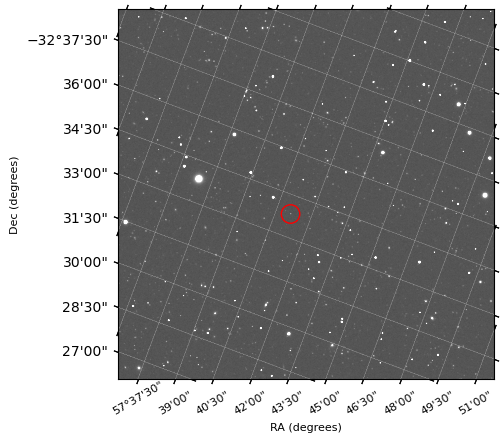

In [134]:
from lsst.geom import Angle, radians, degrees, SpherePoint
import numpy as np
ra_rad = Angle(ra, degrees).asRadians(); dec_rad = Angle(ra, degrees).asRadians()
near = np.argmin([SpherePoint(ra,dec, degrees).separation(SpherePoint(sources["coord_ra"][i],sources["coord_dec"][i], radians)) for i in range(len(sources))])
ax = new_calexp.plot()
new_calexp.add_point(ax,sources[near]["coord_ra"].asDegrees(), sources[near]["coord_dec"].asDegrees(), r = 100)
flux = sources["base_PsfFlux_instFlux"][near]; flux_err = sources["base_PsfFlux_instFluxErr"][near]
photoCalib = new_calexp.expF.getPhotoCalib()
measure = photoCalib.instFluxToMagnitude(flux, flux_err)
measure, measure.value-measure.error, measure.value+measure.error, measure.value-measure.error < 20.6 < measure.value+measure.error

## Calexp basics data

In [136]:
exposureF = calexp.expF
width = exposureF.image.getWidth()
height = exposureF.image.getHeight()

print(f"Calexp size: {width} x {height} pixels")

Calexp size: 4072 x 4000 pixels


In [145]:
pixel_scale = exposureF.getWcs().getPixelScale()
pixel_scale_arcsec = pixel_scale.asArcseconds()
pixel_scale_deg = pixel_scale_arcsec / 3600.0
area_degrees_squared = width * height * (pixel_scale_deg ** 2)
print(f"Area of sky: {area_degrees_squared} deg²")
area_arcsec_squared = width * height * (pixel_scale_arcsec ** 2)
print(f"Area of sky: {area_arcsec_squared} arcsec²")
pixel_scale_arcmin = pixel_scale_arcsec / 60
area_arcmin_squared = width * height * (pixel_scale_arcmin ** 2)
print(f"Area of sky: {area_arcmin_squared} arcmin²")

Area of sky: 0.0500855905650362 deg²
Area of sky: 649109.2537228692 arcsec²
Area of sky: 180.30812603413037 arcmin²
